In [1]:
%matplotlib inline

from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size= np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
         
    if shape:
        image = image.resize(shape, Image.LANCZOS)
        
    if transform:
        image = transform(image).unsqueeze(0)
        
    return image.to(device)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
]) # 来自ImageNet的mean和variance

content = load_image("C:/Users/woaid/OneDrive/Desktop/png/content.png", transform, max_size=400)
style = load_image("C:/Users/woaid/OneDrive/Desktop/png/style.png", transform, shape=[content.size(2), content.size(3)])

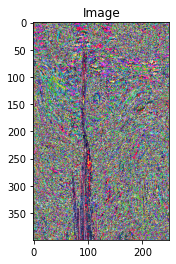

In [5]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style[0], title='Image')
# content.shape

In [6]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


target = content.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()

In [7]:
target_features = vgg(target)

In [10]:
total_step = 5000
style_weight = 100.
for step in range(total_step):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    style_loss = 0
    content_loss = 0
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        content_loss += torch.mean((f1-f2)**2)
        _, c, h, w = f1.size()
        f1 = f1.view(c, h*w)
        f3 = f3.view(c, h*w)
        
        # 计算gram matrix
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        style_loss += torch.mean((f1-f3)**2)/(c*h*w)
        
    loss = content_loss + style_weight * style_loss
    
    # 更新target
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print("Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}"
             .format(step, total_step, content_loss.item(), style_loss.item()))  

Step [0/5000], Content Loss: 46.4350, Style Loss: 36.3503
Step [10/5000], Content Loss: 46.6988, Style Loss: 35.0756
Step [20/5000], Content Loss: 46.9559, Style Loss: 33.8789
Step [30/5000], Content Loss: 47.2074, Style Loss: 32.7554
Step [40/5000], Content Loss: 47.4507, Style Loss: 31.6999
Step [50/5000], Content Loss: 47.6852, Style Loss: 30.7083
Step [60/5000], Content Loss: 47.9114, Style Loss: 29.7753
Step [70/5000], Content Loss: 48.1292, Style Loss: 28.8972
Step [80/5000], Content Loss: 48.3380, Style Loss: 28.0693
Step [90/5000], Content Loss: 48.5428, Style Loss: 27.2872
Step [100/5000], Content Loss: 48.7439, Style Loss: 26.5480
Step [110/5000], Content Loss: 48.9395, Style Loss: 25.8489
Step [120/5000], Content Loss: 49.1314, Style Loss: 25.1878
Step [130/5000], Content Loss: 49.3191, Style Loss: 24.5618
Step [140/5000], Content Loss: 49.5028, Style Loss: 23.9688
Step [150/5000], Content Loss: 49.6827, Style Loss: 23.4061
Step [160/5000], Content Loss: 49.8557, Style Loss:

Step [1370/5000], Content Loss: 58.5020, Style Loss: 6.8831
Step [1380/5000], Content Loss: 58.5347, Style Loss: 6.8389
Step [1390/5000], Content Loss: 58.5676, Style Loss: 6.7949
Step [1400/5000], Content Loss: 58.6006, Style Loss: 6.7513
Step [1410/5000], Content Loss: 58.6330, Style Loss: 6.7080
Step [1420/5000], Content Loss: 58.6641, Style Loss: 6.6651
Step [1430/5000], Content Loss: 58.6948, Style Loss: 6.6224
Step [1440/5000], Content Loss: 58.7251, Style Loss: 6.5800
Step [1450/5000], Content Loss: 58.7558, Style Loss: 6.5379
Step [1460/5000], Content Loss: 58.7858, Style Loss: 6.4961
Step [1470/5000], Content Loss: 58.8145, Style Loss: 6.4546
Step [1480/5000], Content Loss: 58.8434, Style Loss: 6.4134
Step [1490/5000], Content Loss: 58.8727, Style Loss: 6.3724
Step [1500/5000], Content Loss: 58.9022, Style Loss: 6.3317
Step [1510/5000], Content Loss: 58.9321, Style Loss: 6.2914
Step [1520/5000], Content Loss: 58.9618, Style Loss: 6.2513
Step [1530/5000], Content Loss: 58.9909,

Step [2740/5000], Content Loss: 61.5994, Style Loss: 2.9073
Step [2750/5000], Content Loss: 61.6157, Style Loss: 2.8893
Step [2760/5000], Content Loss: 61.6318, Style Loss: 2.8715
Step [2770/5000], Content Loss: 61.6485, Style Loss: 2.8538
Step [2780/5000], Content Loss: 61.6647, Style Loss: 2.8362
Step [2790/5000], Content Loss: 61.6814, Style Loss: 2.8188
Step [2800/5000], Content Loss: 61.6974, Style Loss: 2.8015
Step [2810/5000], Content Loss: 61.7135, Style Loss: 2.7843
Step [2820/5000], Content Loss: 61.7294, Style Loss: 2.7672
Step [2830/5000], Content Loss: 61.7458, Style Loss: 2.7503
Step [2840/5000], Content Loss: 61.7613, Style Loss: 2.7335
Step [2850/5000], Content Loss: 61.7768, Style Loss: 2.7169
Step [2860/5000], Content Loss: 61.7920, Style Loss: 2.7004
Step [2870/5000], Content Loss: 61.8069, Style Loss: 2.6840
Step [2880/5000], Content Loss: 61.8227, Style Loss: 2.6678
Step [2890/5000], Content Loss: 61.8376, Style Loss: 2.6518
Step [2900/5000], Content Loss: 61.8526,

Step [4110/5000], Content Loss: 63.2403, Style Loss: 1.4125
Step [4120/5000], Content Loss: 63.2469, Style Loss: 1.4070
Step [4130/5000], Content Loss: 63.2532, Style Loss: 1.4014
Step [4140/5000], Content Loss: 63.2631, Style Loss: 1.3958
Step [4150/5000], Content Loss: 63.2692, Style Loss: 1.3904
Step [4160/5000], Content Loss: 63.2750, Style Loss: 1.3850
Step [4170/5000], Content Loss: 63.2834, Style Loss: 1.3796
Step [4180/5000], Content Loss: 63.2908, Style Loss: 1.3742
Step [4190/5000], Content Loss: 63.2972, Style Loss: 1.3690
Step [4200/5000], Content Loss: 63.3037, Style Loss: 1.3639
Step [4210/5000], Content Loss: 63.3123, Style Loss: 1.3586
Step [4220/5000], Content Loss: 63.3201, Style Loss: 1.3535
Step [4230/5000], Content Loss: 63.3273, Style Loss: 1.3484
Step [4240/5000], Content Loss: 63.3367, Style Loss: 1.3431
Step [4250/5000], Content Loss: 63.3427, Style Loss: 1.3383
Step [4260/5000], Content Loss: 63.3523, Style Loss: 1.3331
Step [4270/5000], Content Loss: 63.3589,

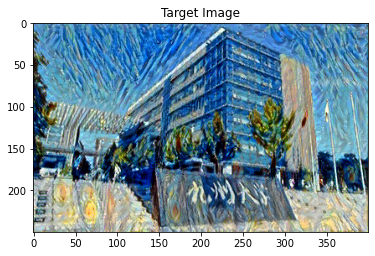

In [11]:
denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)
plt.figure()
imshow(img, title='Target Image')